In [379]:
import os
import numpy as np
import csv
import h5py
import matplotlib.gridspec as gds
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pickle
import scipy.optimize
from math import pi
import pandas as pd
import pyret
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import TweedieRegressor


# Fit LNP-Model via log-likelihood minimization

1) Create design matrix of stimulus with shape T,d, where T is the number of timepoints and d is the filter length. 
2) Create result-vector Y with shape 1,T, contraining the spike count at each timepoint
3) Assume the neuron fires poisson-like with P(lambda) and lambda = exp(theta*X). theta*X is the linear prediction of the firing rate,which is then passed though an exponential function that is the nonliniarity. The spike count y' is then predicted by sampling from P(lambda), the poission distribution.
4) The parameter vector theta is the linear filter of the model, which needs to be estimated. To do that, we take the likelihood of theta given X and y.That is P(y|X,theta) for a range of thetas.Then perform the logarithm on that function and find the mimunum, that is where the derivative of the negative-log-likelihood is 0. 


In [380]:
def make_design_matrix(stim,nb_repeats,nb_frames_by_repetition = 600, td=40, stimulus_dimension = (24,24) ):
    """Create time-lag design matrix from stimulus intensity vector.

    Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

    Returns
    X (2D array): GLM design matrix with shape T, d = dt*x*y

    """

    #initialize te matrix, each row contains preceeding stim of len dt*x*y for all timepoints 
    X = np.zeros((nb_frames_by_repetition*nb_repeats,td*stimulus_dimension[0]*stimulus_dimension[1]))
    for repetition in range(nb_repeats):

        for t in range(td,nb_frames_by_repetition):

            sequence_offset = repetition*nb_frames_by_repetition # start at time bin nb_staframes in the PSTH
            preceeding_stim = stim[sequence_offset+t-td:sequence_offset+t,:,:].ravel()
            X[t+sequence_offset,:] = preceeding_stim

    return -1*X


def design_matrix_2D(stimulus,td=40):
    
    stimulus_timesteps = stimulus.shape[0]+td
    preceeding_stimulus_length = stimulus.shape[1]*stimulus.shape[2]*td
    
    stimulus_padded = np.concatenate((np.zeros((td,stimulus.shape[1],stimulus.shape[2])),stimulus))
    X = np.zeros((stimulus_timesteps,preceeding_stimulus_length))
    
    for t in range(stimulus_timesteps):
        if t < td:
            continue
        else:
            X[t,:] = stimulus_padded[t-td:t,:,:].ravel()
        
    return X[td:,:]


# def make_design_matrix_1D(stim, td=40 ):
#     """Create time-lag design matrix from stimulus intensity vector.

#     Args:
#     stim (1D array): Stimulus intensity at each time point.
#     d (number): Number of time lags to use.

#     Returns
#     X (2D array): GLM design matrix with shape T, d = dt*x*y

#     """


#     #initialize te matrix, each row contains preceeding stim of len dt*x*y for all timepoints 
#     X = np.zeros((len(stim)+td,td))

#     for t in range(td,len(stim)):

#         preceeding_stim = stim[t-td:t]
#         X[t,:] = preceeding_stim

#     return -1*X



def bin_spikes(template, nb_repeats, frames_by_repetition = 600):

    binned_spikes = np.empty((nb_repeats,frames_by_repetition)) #store spikes emitted after each frame for all repeats
    for i in range(nb_repeats):
        binned_spikes[i,:] = np.histogram(rasters_check[template][i], bins=frames_by_repetition, range=(0,15))[0]

    spike_count = np.concatenate(binned_spikes, axis = 0 ) # concatenate all repeats to get a vector 1,T
                                 
    return spike_count


def neg_log_lik_lnp(theta, X, y):
    """Return -loglike for the Poisson GLM model.

    Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

    Returns:
    number: Negative log likelihood.

    """

    # Compute the Poisson log likeliood
    rate = np.exp(X @ theta)
    log_lik = y.T @ np.log(rate)  - rate.sum() #- np.ones_like(y)*rate

    return -1* log_lik



def fit_lnp(spikes,X, d=40,stimulus_dimension = (24,24)):
    """Obtain MLE parameters for the Poisson GLM.

    Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

    Returns:
    1D array: MLE parameters

    """


    # Build the design matrix
    y = spikes
    constant = np.ones_like(y)
    #X = np.column_stack([constant, make_design_matrix(stim, nb_repeats)])
    X = np.column_stack([constant, X])

    # Use a random vector of weights to start (mean 0, sd .2)
    x0 = np.random.normal(0, .2, d*stimulus_dimension[0]*stimulus_dimension[1] + 1)

    # Find parameters that minmize the negative log likelihood function
    res = scipy.optimize.minimize(neg_log_lik_lnp, x0,args=(X, y))

    return res['x']





def separate_components(sta):
    """Separate space and time components."""

    time_width, space_height, space_width = sta.shape[0], sta.shape[1], sta.shape[2]
    rf_shape = (time_width, space_height * space_width)
    rf = np.reshape(sta, rf_shape)

    # # Remove the median.
    # rf_median = np.median(rf)
    # rf = rf - rf_median

    u, s, vh = np.linalg.svd(rf, full_matrices=False)

    time_rf_shape = (time_width,)
    time_rf = np.reshape(u[:, 1], time_rf_shape)  # TODO why 1 instead of 0?
    space_rf_shape = (space_height, space_width)
    space_rf = np.reshape(vh[1, :], space_rf_shape)  # TODO understand why 1 instead of 0?

    # Determine the cell polarity
    if np.abs(np.max(rf) - np.median(rf)) >= np.abs(np.min(rf) - np.median(rf)):
        rf_polarity = 'ON'
    else:
        rf_polarity = 'OFF'
        
    # Determine the spatial RF polarity
    if np.abs(np.max(space_rf) - np.median(space_rf) >= np.abs(np.min(space_rf) - np.median(space_rf))):
        space_rf_polarity = 'ON'
    else:
        space_rf_polarity = 'OFF'
        
    # Determine the temporal RF polarity
    if np.abs(np.max(time_rf) - np.median(time_rf) >= np.abs(np.min(time_rf) - np.median(time_rf))):
        time_rf_polarity = 'ON'
    else:
        time_rf_polarity = 'OFF'
        
    # Reverse components (if necessary).
    if rf_polarity != space_rf_polarity:
        space_rf = - space_rf
        
    if rf_polarity != time_rf_polarity:
        time_rf = - time_rf

    return time_rf, space_rf



def N(l,threshold = 0):
    if l <=threshold :
        return 0
    else :
        return l

# read the responses to the checkerboard stimulus 

In [225]:
#read raster responses to checkerboard
filename = "/user/sebert/home/Documents/Experiments/OSR/Results/20210326_Thomas/resultfiles/sta_data.pkl"
with open(filename, "rb") as handle:   #Pickling
    stadict = pickle.load(handle)
    
stadict.keys()


rasters_check_rep = stadict['rasters_check_repeated']
rasters_check = stadict['rasters_check']





# read euler responses

In [227]:
#load cell response
filename = "/user/sebert/home/Documents/Experiments/OSR/Results/20210326_Thomas/resultfiles/20210326_euler_grade_isi.pkl"
with open(filename, "rb") as handle:   #Pickling
    infodict = pickle.load(handle)
    
def get_euler_response(cell):
    return infodict[f'temp_{cell}']['control']['euler_count']



# read the stimulus

In [228]:

#load checkerboard stimulus
nb_checks = 24
nb_frames = 120000

stimulus_path = "/user/sebert/home/Documents/Experiments/OSR/DataAnalysis/STA/checkerboard_{}checks_{}frames.npy".format(nb_checks,nb_frames)

#checkerboard_24checks_120000frames = np.ones((nb_frames,nb_checks,nb_checks), dtype='uint8')
checkerboard_24checks_120000frames = np.load(stimulus_path)

#stimulus for one repeated sequence
checker_repeats = checkerboard_24checks_120000frames[:600]
checker_repeats = checker_repeats.astype(np.float64)

stimulus = checker_repeats
stimulus -= stimulus.mean()
stimulus /= stimulus.std()



checker = checkerboard_24checks_120000frames.astype(np.float64)
stimulusnonrepeated = checker
stimulusnonrepeated -= stimulusnonrepeated.mean()
stimulusnonrepeated /= stimulusnonrepeated.std()


# read euler stimulus

In [229]:
#load stimulus 
stimeuler = pd.read_csv('/user/sebert/home/Documents/Experiments/OSR/StimulusDesgin/Euler_Baptiste/euler_luminance_profile.csv')
euler = np.asarray(stimeuler['luminance'])

euler = euler/euler.mean()
euler = euler - euler.std()


euler_time = np.arange(0,30,0.02)


euler_2D = np.zeros((24,24,len(euler)))
for i in range(len(euler)):
    euler_2D[:,:,i] = euler[i]

# choose a cell

In [284]:
#choose a cell
c = 5

# Fit LNP model  

In [285]:
# define some parameter
nb_repeats= len(rasters_check[0])
d = 40
stimulus_dimension = (24,24)


In [286]:
#create design matrix and count spikes for each timepoint
#X = make_design_matrix(stimulusnonrepeated,nb_repeats)
y = bin_spikes(c, nb_repeats)


In [287]:
X.shape,y.shape

((54000, 23040), (54000,))

## use sci-kit to fit theta 

In [403]:
#sci-kit learn
reg = TweedieRegressor(power=1, alpha=1, link='log')
reg.fit(X,y)


TweedieRegressor(alpha=1, link='log', power=1)

In [404]:
#get the STA
theta = reg.coef_
sta_scikit = theta.reshape((d,stimulus_dimension[0],stimulus_dimension[1]))
theta.shape,sta_scikit.shape

((23040,), (40, 24, 24))

# visualize linear filter obtained with different methods 

In [290]:
stimulus_frequency = 40
td = 40
frame_rate = 1/stimulus_frequency
filtertime = np.arange(-td,0)*frame_rate

Text(0.5, 0.98, 'Spike Triggered Average for  cell 5')

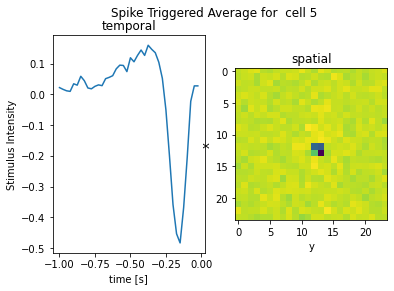

In [291]:
#plot STA
STA = stadict['STAs'][c]
STA = (STA- STA.mean())/STA.std()
temporal = stadict['temporal'][c]
spatial = stadict['spatial'][c]


fig,ax = plt.subplots(1,2)
ax[0].plot(filtertime,temporal)
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].set_title('temporal')

ax[1].imshow(spatial)
ax[1].set_title('spatial')
ax[1].set_xlabel('y')
ax[1].set_ylabel('x')
fig.suptitle(f"Spike Triggered Average for  cell {c}")

In [292]:
spatial.max()

0.06526247836426673

Text(0.5, 0.98, 'theta obtained via minimization with sci-kit')

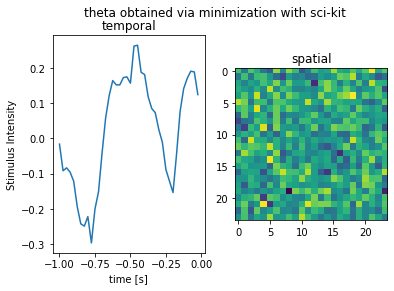

In [293]:
#plot sci-kit estimation 
time_rf, space_rf = separate_components(sta_scikit)
filtertime = np.arange(-d,0)*frame_rate

fig,ax = plt.subplots(1,2)
ax[0].plot(filtertime,time_rf)
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].set_title('temporal')

ax[1].imshow(space_rf)
ax[1].set_title('spatial')
fig.suptitle(f'theta obtained via minimization with sci-kit')

# predict repeated sequence response with different methods

/user/sebert/home/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


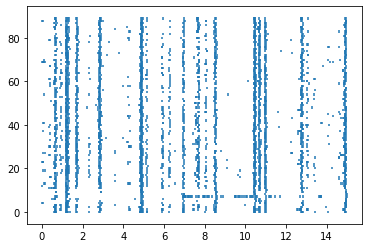

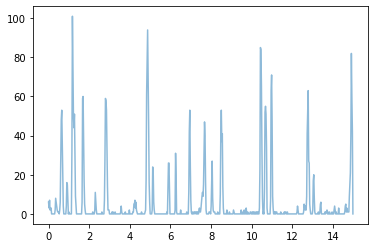

In [294]:
#get response to repeated checker sequence
repeated_checker_response = np.asarray(rasters_check_rep[c])
count,bins = np.histogram(np.concatenate(repeated_checker_response), bins = 600, range = (0,15))
plt.eventplot(repeated_checker_response)
plt.figure()
plt.plot(bins[:-1],count, alpha = .5)


In [410]:
# get design matrix of repeated seaquence
X_rep = design_matrix_2D(stimulus)

In [411]:
teststim = np.zeros(stimulus.shape)
teststim[0,:,:] = 1

In [412]:
#X_rep = make_design_matrix(teststim,nb_repeats = 1)

## predict with STA and exponential as nonlinearity

In [419]:
STA_vec = STA.flatten()
linp_STA_1 = X_rep @ STA_vec
linp_STA_1 = np.dot(X_rep,STA_vec)



#linp_STA_1 = (linp_STA_1-linp_STA_1.mean())/linp_STA_1.std() 
#count = (count-count.mean())/count.std()
def normalize(inp):
    x = inp.copy()
    for i,xi in enumerate(x):
        x[i] = (xi - np.min(x)) / (np.max(x) - np.min(x))

    return x
    

# linp_STA_1 = normalize(linp_STA_1)
count = normalize(count)


In [420]:
#compare linear prediction with dot product and convolution
linp_STA_pyret = pyret.filtertools.linear_response(STA,stimulus) 
linp_STA_pyret = normalize(linp_STA_pyret)

(0.0, 100.0)

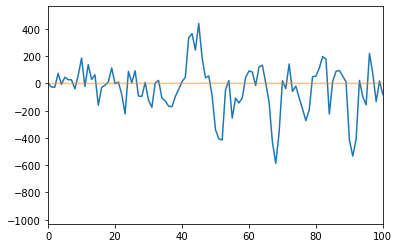

In [426]:
plt.plot(linp_STA_1)
#plt.plot(linp_STA_pyret)
#plt.plot(linp_STA_2)
plt.plot(count, alpha = .5)
plt.xlim(0,100)
#plt.plot(linp_STA_pyret/linp_STA_pyret.max())

In [422]:
prediction_STA_exp = np.exp(linp_STA_1)

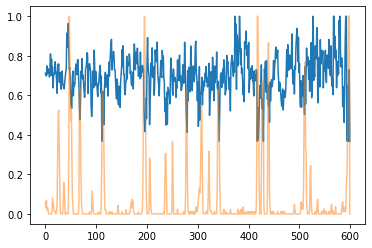

In [417]:
#plt.plot(linp_STA)
plt.plot(prediction_STA_exp/prediction_STA_exp.max())
plt.plot(count/count.max(), alpha = .5)


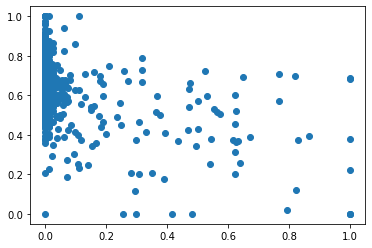

In [418]:
plt.scatter(count,linp_STA_1)

## predict with STA and rectification as nonlinearity

In [347]:
STA_vec = STA.ravel()

linp_STA = X_rep @ STA_vec

linp_STA -= linp_STA.mean()
linp_STA /= linp_STA.std()

In [348]:
prediction_STA_N = np.array([N(l) for l in linp_STA])

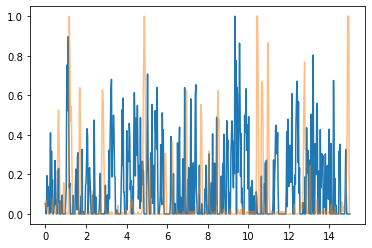

In [349]:
#plt.plot(linp_STA)
plt.plot(np.linspace(0,15,600),prediction_STA_N/prediction_STA_N.max())
plt.plot(bins[:-1],count/count.max(), alpha = .5)


## predict with scikit

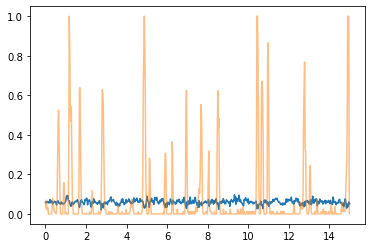

In [350]:
#predict the firing rate for repeated sequences
plt.plot(np.linspace(0,15,600),reg.predict(X_rep))
plt.plot(bins[:-1],count/count.max(), alpha = .5)

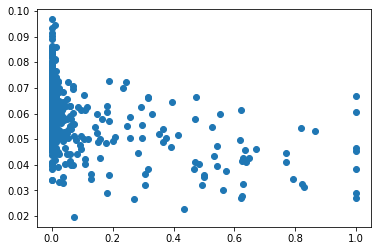

In [351]:
plt.scatter(count,reg.predict(X_rep))

# predict euler response

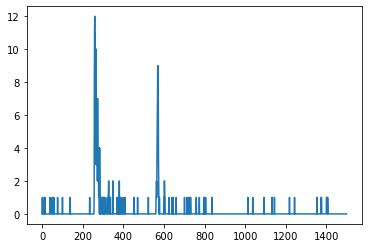

In [352]:
euler_resp = get_euler_response(c)
plt.plot(euler_resp)

In [353]:
X_euler_1D = make_design_matrix_1D(euler)

In [383]:
euler_2D = np.zeros((len(euler),24,24))
for i in range(len(euler)):
    euler_2D[i,:,:] = euler[i]
X_euler_2D = make_design_matrix(euler_2D, nb_repeats = 1,nb_frames_by_repetition = len(euler))

## predict with STA and exponential as nonlinearity

In [384]:
#take only temporal STA
STA_temporal = temporal
linp_STA = X_euler_1D @ STA_temporal

linp_STA -= linp_STA.mean()
linp_STA /= linp_STA.std()

prediction_STA_exp = np.exp(linp_STA)

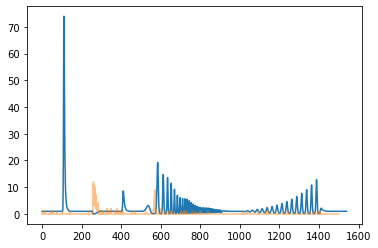

In [385]:
#plt.plot(linp_STA)
plt.plot(prediction_STA_exp)
plt.plot(euler_resp, alpha = .5)


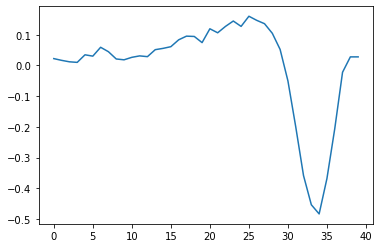

In [386]:
plt.plot(temporal)

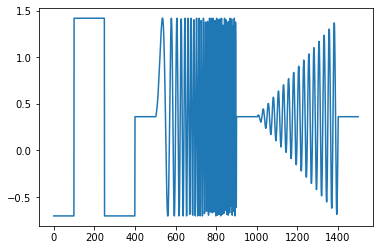

In [387]:
plt.plot(euler)

In [388]:
#take spatiotemporal STA

linp_STA = X_euler_2D @ STA_vec

linp_STA -= linp_STA.mean()
linp_STA /= linp_STA.std()

prediction_STA_exp = np.exp(linp_STA)

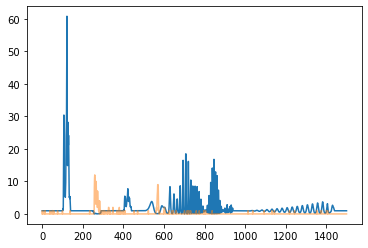

In [389]:
#plt.plot(linp_STA)
plt.plot(prediction_STA_exp)
plt.plot(euler_resp, alpha = .5)


## predict with STA and rectification as nonlinearity

In [390]:
#take only temporal STA
STA_temporal = temporal
linp_STA = X_euler_1D @ STA_temporal

linp_STA -= linp_STA.mean()
linp_STA /= linp_STA.std()

prediction_STA_N = np.array([N(l) for l in linp_STA])

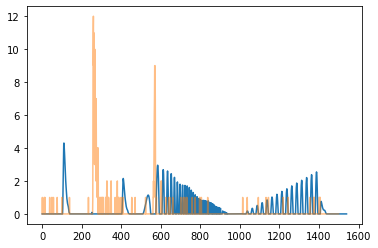

In [391]:
#plt.plot(linp_STA)
plt.plot(prediction_STA_N)
plt.plot(euler_resp, alpha = .5)


In [392]:
#take spatiotemporal STA
linp_STA = X_euler_2D @ STA_vec

linp_STA -= linp_STA.mean()
linp_STA /= linp_STA.std()

prediction_STA_N = np.array([N(l) for l in linp_STA])

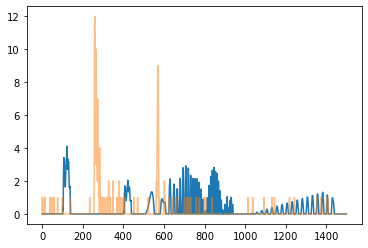

In [393]:
#plt.plot(linp_STA)
plt.plot(prediction_STA_N)
plt.plot(euler_resp, alpha = .5)


## predict with scikit

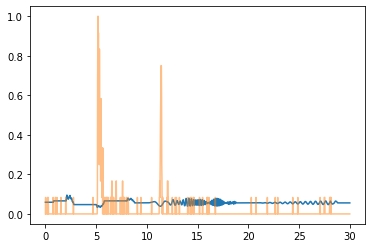

In [394]:
#predict the firing rate for repeated sequences
plt.plot(euler_time,reg.predict(X_euler_2D))
plt.plot(euler_time,euler_resp/euler_resp.max(), alpha = .5)

# predict training data

In [398]:
#with STA and exponenital
linp_STA = X @ STA_vec

linp_STA -= linp_STA.mean()
linp_STA /= linp_STA.std()

prediction_STA_exp = np.exp(linp_STA)

(0.0, 200.0)

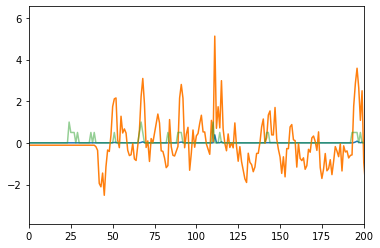

In [401]:
plt.plot(prediction_STA_exp/prediction_STA_exp.max())
plt.plot(linp_STA)
plt.plot(y/y.max(),alpha = .5)
plt.xlim(0,200)